# Project - Twitter US Airline Sentiment

**Background and Context:**

Twitter posses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other side, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.


Listening to how customers feel about the product/services on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.

 

**Data Description:**

A sentiment analysis job about the problems of each major US airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

 

**Dataset:**

The dataset has the following columns:

- tweet_id                                                           
- airline_sentiment                                               
- airline_sentiment_confidence                               
- negativereason                                                   
- negativereason_confidence                                    
- airline                                                                   
- airline_sentiment_gold                                              
- name     
- negativereason_gold 
- retweet_count
- text
- tweet_coord
- tweet_created
- tweet_location 
- user_timezone


**Objective:**

To implement the techniques learned as a part of the course.

# 1. Importing Libraries and Loading the Dataset

**Connecting to Google Drive**

In [ ]:
from google.colab import drive  # Libary to access the user's Google Drive folders and files

In [ ]:
drive.mount("/content/drive")   # Linking to the user's Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Libraries for manipulating numbers, datasets and displaying graphs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install contractions                         # installing library to remove contractions

import contractions                               # library for removing contractions
import re                                         # regular expression library
import unicodedata                                # library for removing special characters

from bs4 import BeautifulSoup                     # library for removing html tags
import nltk                                       # library for NLP
from nltk.tokenize import word_tokenize           # library for splitting text blocks into words
from nltk.corpus import stopwords                 # library for stop words
from nltk.corpus import wordnet                   # library for parts of speech
from nltk.stem.wordnet import WordNetLemmatizer   # library for lemmatizing words

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # libraries to transform words into vectors
from sklearn.model_selection import train_test_split                          # library to divide data into training and testing
from sklearn.metrics import confusion_matrix, classification_report           # library to summarize model performance per class

nltk.download("punkt")                            # downloading necessary library dictionaries
nltk.download("stopwords")                        # downloading english stop words
nltk.download('averaged_perceptron_tagger')       # downloading the parts of speech
nltk.download("wordnet")                          # downaloading wordnet

from tensorflow.keras.models import Sequential                                                    # Basic wrapper to build model inside
from tensorflow.keras.layers import Dense, Dropout                                                # Dense layer is for the ANN , Dropout used to control overfitting
from tensorflow.keras.utils import to_categorical                                                 # Function to convert the categorical target classes into tensors for the neural network
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping                             # Used to control overfitting and store the best model during the epochs of training
from tensorflow.keras import backend                                                              # Used to clear memory (RAM)

# Seeding the random number generator to ensure the model building process is repeatable
import random
random.seed(0)  # The number zero is not special, basically any integer works

# Library to over sample the data in order to balance the target classes
from imblearn.over_sampling import SMOTE

# Command for the notebook to display graphs (in this case images) in the notebook
%matplotlib inline
sns.set(color_codes=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
airData = pd.read_csv("/content/drive/My Drive/AIML/8.0/Week 3 Project/Tweets.csv")   # loading the dataset

In [ ]:
airData.shape   # displaying the shape of the dataset

(14640, 15)

There are 14,640 tweets in the dataset with 15 different columns.

In [ ]:
airData.describe().T    # displaying summary information of the dataset for columns containing numbers

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


- `tweet_id` does not contain any useful information and will be dropped further on.
- Airline sentiment confidence is high with a mean of 0.9 (closer to 1 is better).
- Negative reason confidence is mediocre at a mean of 0.63.
- At least 75% of tweets had no retweets.

In [ ]:
airData.describe(include="O").T   # displaying summary information of the dataset for columns containing words

,count,unique,top,freq
airline_sentiment,14640,3,negative,9178
negativereason,9178,10,Customer Service Issue,2910
airline,14640,6,United,3822
airline_sentiment_gold,40,3,negative,32
name,14640,7701,JetBlueNews,63
negativereason_gold,32,13,Customer Service Issue,12
text,14640,14427,@united thanks,6
tweet_coord,1019,832,"[0.0, 0.0]",164
tweet_created,14640,14247,2015-02-24 09:54:34 -0800,5
tweet_location,9907,3081,"Boston, MA",157


- The majority of the tweets are negative in sentiment.
  - This means our target class is unbalanced which we will deal with later on.
- Customers listed customer service as the most frequent reason for their negative sentiment.
- United airlines has the most tweets of any airline in this dataset.
- Tweet meta data does not seem to be helpful based on the number of missing values or values of zero.

# 2. Brief View of the Data

a. Dropping all columns except `text` and `airline_sentiment`

In [ ]:
airData = airData[["text", "airline_sentiment"]]    # Grabbing only the two columns we care about

b. The new shape of the data

In [ ]:
airData.shape   # printing the shape of the reduced data

(14640, 2)

We are now down to only two columns.

c. Viewing the first five rows

In [ ]:
airData.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


d. Checking for missing values

In [ ]:
airData.isnull().sum()    # printing the number of missing or null values

text                 0
airline_sentiment    0
dtype: int64

There are no null or missing values.

# 3. Text Preprocessing

### a. HTML Tag Removal

In [ ]:
# Using the BeautifulSoup function to remove any html tags from the tweet text by
# Applying a lambda function on each of the dataframe's text cell
airData["text"] = airData["text"].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
airData.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


### Contraction Removal

In [ ]:
# Using the contraction function to transform any contractions to their full words from the tweet text by
# Applying a lambda function on each of the dataframe's text cell
airData["text"] = airData["text"].apply(lambda x: contractions.fix(x))
airData.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you have added commercials...,positive
2,@VirginAmerica I did not today... Must mean I ...,neutral
3,@VirginAmerica it is really aggressive to blas...,negative
4,@VirginAmerica and it is a really big bad thin...,negative


### b. Tokenization

In [ ]:
# Using word_tokenize function to split the text in each tweet into a list of words by
# Applying a lambda function on each of the dataframe's text cell
airData["text"]= airData["text"].apply(lambda x: word_tokenize(x))
airData.head()

,text,airline_sentiment
0,"[@, VirginAmerica, What, @, dhepburn, said, .]",neutral
1,"[@, VirginAmerica, plus, you, have, added, com...",positive
2,"[@, VirginAmerica, I, did, not, today, ..., Mu...",neutral
3,"[@, VirginAmerica, it, is, really, aggressive,...",negative
4,"[@, VirginAmerica, and, it, is, a, really, big...",negative


### c. Number Removal

In [ ]:
# Using regular expressions to remove any numbers (not spelled out) from the tweet text by
# Applying a lambda function on each of the dataframe's text cell
airData["text"] = airData["text"].apply(lambda words: [re.sub(pattern=r"\d+", repl="", string=word) for word in words])
airData.head()

,text,airline_sentiment
0,"[@, VirginAmerica, What, @, dhepburn, said, .]",neutral
1,"[@, VirginAmerica, plus, you, have, added, com...",positive
2,"[@, VirginAmerica, I, did, not, today, ..., Mu...",neutral
3,"[@, VirginAmerica, it, is, really, aggressive,...",negative
4,"[@, VirginAmerica, and, it, is, a, really, big...",negative


### d. Removal of Special Characters and Punctuation

In [ ]:
# Using the unicodedata function to remove any special characters that are not in the normal english language from the tweet text by
# Applying a lambda function on each of the dataframe's text cell
airData["text"] = airData["text"].apply(lambda words: [unicodedata.normalize("NFKD", word).encode("ascii", "ignore").decode("utf-8", "ignore") for word in words])
airData.head()

,text,airline_sentiment
0,"[@, VirginAmerica, What, @, dhepburn, said, .]",neutral
1,"[@, VirginAmerica, plus, you, have, added, com...",positive
2,"[@, VirginAmerica, I, did, not, today, ..., Mu...",neutral
3,"[@, VirginAmerica, it, is, really, aggressive,...",negative
4,"[@, VirginAmerica, and, it, is, a, really, big...",negative


In [ ]:
# Using regular expressions to remove symbols like @ signs, etc. from the tweet text by
# Applying a lambda function on each of the dataframe's text cell
airData["text"] = airData["text"].apply(lambda words: [re.sub(pattern=r"[^\w\s]", repl="", string=word) for word in words])
airData["text"] = airData["text"].apply(lambda words: [word for word in words if word != ""])

airData.head()

,text,airline_sentiment
0,"[VirginAmerica, What, dhepburn, said]",neutral
1,"[VirginAmerica, plus, you, have, added, commer...",positive
2,"[VirginAmerica, I, did, not, today, Must, mean...",neutral
3,"[VirginAmerica, it, is, really, aggressive, to...",negative
4,"[VirginAmerica, and, it, is, a, really, big, b...",negative


### e. Stop Word Removal

In [ ]:
stopWords = stopwords.words('english')    # loading the english stopwords

stopWords = set(stopWords) - set("not")   # removing the word "not" from set of stopwords since it can convey meaning for sentiment
                                          # there is no need to remove the contraction words the set as there are no longer contractions in our dataset

In [ ]:
# Removing any stop words from the tweet text by
# Applying a lambda function on each of the dataframe's text cell
airData["text"] = airData["text"].apply(lambda words: [word for word in words if word not in stopWords])
airData.head()

,text,airline_sentiment
0,"[VirginAmerica, What, dhepburn, said]",neutral
1,"[VirginAmerica, plus, added, commercials, expe...",positive
2,"[VirginAmerica, I, today, Must, mean, I, need,...",neutral
3,"[VirginAmerica, really, aggressive, blast, obn...",negative
4,"[VirginAmerica, really, big, bad, thing]",negative


### f. Conversion to Lowercase

In [ ]:
# Lowercasing all letters in the tweet text by
# Applying a lambda function on each of the dataframe's text cell
airData["text"] = airData["text"].apply(lambda words: [word.lower() for word in words])
airData.head()

,text,airline_sentiment
0,"[virginamerica, what, dhepburn, said]",neutral
1,"[virginamerica, plus, added, commercials, expe...",positive
2,"[virginamerica, i, today, must, mean, i, need,...",neutral
3,"[virginamerica, really, aggressive, blast, obn...",negative
4,"[virginamerica, really, big, bad, thing]",negative


### g. Lemmatize

In [ ]:
wnl = WordNetLemmatizer()                             # Initializing the lemmatizer

# Custom function to evaluate the part of speech of a word (i.e. adjective, noun, verb, adverb)
def getPOS(word):
    posTag = nltk.pos_tag([word])[0][1][0].upper()    # Uses nltk library to identify word part of speech
    tag_dict = {"J": wordnet.ADJ,                     # Dictionary to convert the pos_tag into what the lemmatizer can use
                "N": wordnet.NOUN,
                "VBG": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(posTag, wordnet.NOUN)         # Returns the part of speech of the provided word, or if unknown, returns noun as a default

In [ ]:
# Using the lemmatize function to reduce words to their root words that are also in the dictionary from the tweet text by
# Applying a lambda function on each of the dataframe's text cell
# Also incorporates the custom part of speech function to help the lemmatizer
airData["text"] = airData["text"].apply(lambda words: [wnl.lemmatize(word=word, pos=getPOS(word)) for word in words])
airData.head()

,text,airline_sentiment
0,"[virginamerica, what, dhepburn, said]",neutral
1,"[virginamerica, plus, added, commercial, exper...",positive
2,"[virginamerica, i, today, must, mean, i, need,...",neutral
3,"[virginamerica, really, aggressive, blast, obn...",negative
4,"[virginamerica, really, big, bad, thing]",negative


### h & i. Joining the words back together

In [ ]:
# Combining the list of words of each tweet into a single "sentence" by
# Applying a lambda function on each of the dataframe's text cell
airData["text"] = airData["text"].apply(lambda words: " ".join(words))
airData.head()

,text,airline_sentiment
0,virginamerica what dhepburn said,neutral
1,virginamerica plus added commercial experience...,positive
2,virginamerica i today must mean i need take an...,neutral
3,virginamerica really aggressive blast obnoxiou...,negative
4,virginamerica really big bad thing,negative


# 4. Vectorization

### a. Using CountVectorizer

CountVectorizer simply counts the number of times a given word or number of words appears in each tweet and returns an array with that information.  Since we only have a little over 14,000 tweets we will limit the maximum number of features to 3000 so as not to have too many features with respect to the size of our dataset.  This will also aid in reducing the training time of our models.

In [ ]:
countV = CountVectorizer(max_features=3000)         # intializing the vectorizer limiting to 3000 words max
countData = countV.fit_transform(airData["text"])   # fitting the vectorizer and transforming the tweets into a count vectorized array
countData.toarray()                                 # displaying a portion of the array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
countData.shape # printing the shape of the vectorized data

(14640, 3000)

The tweets are now transformed into having 3000 columns, the maximum number of words we limited the vectorizer to.

### b. Using TfidfVectorizer

Tfidf vectorization normalizes the word count by increasing the importance of words that occur in fewer of the tweets while decreasing the importance of words that occur in a large number of the tweets.

In [ ]:
tfidfV = TfidfVectorizer(max_features=3000)       # intializing the vectorizer limiting to 3000 words max
tfData = tfidfV.fit_transform(airData["text"])    # fitting the vectorizer and transforming the tweets into a tfidf vectorized array
tfData.toarray()                                  # displaying a portion of the array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
tfData.shape    # printing the shape of the vectorized data

(14640, 3000)

The tweets are now transformed into having 3000 columns, the maximum number of words we limited the vectorizer to.

# 5. Fit and Evaluate Models

## a. Encoding Dependent Variable

The neural network needs the target variable to be an array of vectors and not simply strings (words).

In [ ]:
airData["airline_sentiment"].value_counts()   # printing the number and values of our target variable

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

There are three different sentiments: negative, neutral and positive.  We can see that there are far more negative tweets than positive tweets in the dataset.  We will use upsampling later on to balance these classes.

In [ ]:
# Dictionary to convert the strings of airline sentiment into integers
sentimentDict = {"negative": 0,
                 "neutral": 1,
                 "positive": 2}

In [ ]:
y = airData["airline_sentiment"].apply(lambda x: sentimentDict[x]).values   # Converting the target classes from strings to integers
y = to_categorical(y=y, num_classes=3)                                      # Converting the target classes into vectors the neural network can use
y                                                                           # Displaying some of the new array

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

The target class is now converted to a form the neural network can use to train.

## b. Custom Function to Build Neural Network for the Grid Search Method

In [ ]:
# Custom function for building a ANN model based on different hyperparameters
def buildSequential(numDenseLayers, unitsANN, dropout, optimizer="adam", activation="relu"):

  # Intializing the new model
  gridNN = Sequential()

  # Creating a number of Dense layers equal to numDenseLayers
  for i in np.arange(0, numDenseLayers):
    if i == 0:
      # Adding the first Dense layer with a number of neurons equal to number of units fed to our custom function
      gridNN.add(Dense(unitsANN[i], activation=activation, input_shape=(3000,)))
    else:
      # Adding other Dense layers with a number of neurons equal to number of units fed to our custom function
      gridNN.add(Dense(unitsANN[i], activation=activation))
    # Adding a dropout layer with a rate equal to dropout to help control overfitting
    gridNN.add(Dropout(dropout))

  # Adding the final layer which has a number of neurons equal to the number of sentiments, in this case 3
  # Using softmax to calculate the probablity the input text is each class
  gridNN.add(Dense(3, activation="softmax"))

  # Adding the adam optimizer to our model
  # Using categorical crossentropy for our loss since we have more than two classes
  gridNN.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

  # Returning the CNN model contructed based on inputed hyperparameter values
  return gridNN

## c. CountVectorizer Model

First we will train our model on using the data from CountVectorizer

### Splitting Data into Training, Validation and Testing

We want to split our data into three groups: training, validation and test.  We want 35% of our data to be training, 35% to be validation and 30% to be test data.

To do this we will first split our data into 30% test and 70% other.

In [ ]:
countData = countData.toarray()   # Converting the dependent data to a regular numpy array for the neural network
countData

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Splitting into 30% actual test data and 70% "train" data that we will split below into the actual train data and validation data.
# We are stratifying our data so that train, validation and test will all have equal proportions of each class.
x_train, x_test, y_train, y_test = train_test_split(countData, y, test_size=0.3, stratify=y, random_state=1)

**SMOTE - Oversampling of the data**

We will use the SMOTE function to upsample the `neutral` and `positive` tweets so they have the same number of tweets as the `negative` class.  This will help our model be able to identify each class well instead of only the dominant `negative` class.

In [ ]:
sm = SMOTE(k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
x_train, y_train = sm.fit_resample(x_train, y_train)    # fitting the SMOTE algorithm to the data

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Splitting the rest of the data into equal parts training and validation.
# Again we are stratifying our data to have equal proportions of each class.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5, stratify=y_train, random_state=1)

In [ ]:
# Printing the shape of our independent variables
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)
print()

# Printing the shape of our dependent variable
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

x_train shape: (9637, 3000)
x_val shape: (9638, 3000)
x_test shape: (4392, 3000)

y_train shape: (9637, 3)
y_val shape: (9638, 3)
y_test shape: (4392, 3)


We see our training and validation data has been upsampled and is of equal size.  The test data remained untouched and is 30% of the original dataset size.

### Grid Search Parameters

Grid search is a time intensive process.  The more hyperparameters which are tuned and the greater the number of options we give for each hyperparameter the more combinations we have to train.  Below we have chosen to tune some of the hyperparameters yielding 48 different combinations to train with.

In [ ]:
# The options for the number of dense layers
numDenseLayers = [1, 2, 3, 4]

# The options for the number of neurons in each dense layer
unitsANN = [[64, 64, 64, 64],
            [8, 16, 32, 64],
            [16, 32, 64, 128],
            [32, 32, 32, 32],]

# The options for the dropout values for each dense layer
dropout = [0.5, 0.3, 0.1]

### Fitting the CountVectorizer Model

We now will loop through the different combinations of hyperparameters and fit the model.  We will also employ two Keras callbacks:
- EarlyStopping: stops the training process when the current model has not improved for a given number of epochs
- ModelCheckpoint: saves the best version of the current model at each epoch

In [ ]:
i = 0                 # Initializing a counter to number the current model
bestValLoss = 1000    # Initializing the current "best" validation loss really high so any model will be performing better than it

# Looping through the different hyperparameter options given above, fitting the model with each combination

for dp in dropout:
  for nd in numDenseLayers:
    for ua in unitsANN:
      # Building the current model with a combination of hyperparameters using our custom function
      model = buildSequential(nd, ua, dp)

      # Setting the early stopping callback to stop training when the validation loss has not improved after 10 epochs
      early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=10)

      # Setting the model checkpoint to save the weights of the current model when the validation loss has improved
      model_checkpoint = ModelCheckpoint(filepath= "model_" + str(i) + ".h5",
                          monitor = "val_loss",
                          verbose = 0,
                          save_best_only = True,
                          save_weights_only = True,
                          mode = "auto",
                          save_freq = "epoch")

      # Training the model with 50 as our batch size and 100 epochs
      # The training will probably stop each time before 100 epochs based on the early stopping callback
      # Using x_val and y_val as the validation data
      model.fit(x = x_train,
                y = y_train,
                batch_size=50,
                epochs=100,
                verbose=0,
                validation_data=(x_val, y_val),
                callbacks=[early_stopping, model_checkpoint])
      
      # Loading the weights of the current model saved from its best version
      # The best version of the current model has the lowest validation loss
      model.load_weights(filepath="model_" + str(i) + ".h5")
      
      # Calculating the validation loss and accuracy for the best version of the current model
      valLoss, valAcc = model.evaluate(x=x_val, y=y_val)

      # If the validation loss of the current model is better than all other previous models...
      if valLoss < bestValLoss:
        bestModelNumber = i                                     # Store the current model number
        bestValLoss = valLoss                                   # Store the current model validation score as the best
        bestParameters = [nd, ua, dp]   # Store the current model hyperparameters as the best
        bestModel = model                                       # Store the current model as the best

      # Displaying the finished model number and it's validation loss and accuracy
      print("Model", i, " finished with validation loss of", valLoss, "and validation accuracy of", valAcc)

      # Increasing the model number by one for the next model
      i += 1

      # Clearing up memory (RAM)
      backend.clear_session()

302/302 [==============================] - 1s 2ms/step - loss: 0.5557 - accuracy: 0.7682
Model 0  finished with validation loss of 0.5556889176368713 and validation accuracy of 0.7682091593742371
302/302 [==============================] - 1s 2ms/step - loss: 0.5772 - accuracy: 0.7726
Model 1  finished with validation loss of 0.5771964192390442 and validation accuracy of 0.7725669145584106
302/302 [==============================] - 1s 2ms/step - loss: 0.5624 - accuracy: 0.7700
Model 2  finished with validation loss of 0.5623536109924316 and validation accuracy of 0.7699730396270752
302/302 [==============================] - 1s 2ms/step - loss: 0.5520 - accuracy: 0.7694
Model 3  finished with validation loss of 0.5520438551902771 and validation accuracy of 0.7693504691123962
302/302 [==============================] - 1s 2ms/step - loss: 0.5669 - accuracy: 0.7685
Model 4  finished with validation loss of 0.5668622851371765 and validation accuracy of 0.7685204148292542
302/302 [===========

In [ ]:
# Printing which model performed best
print("Best Model Number:", bestModelNumber)
print("Best Model Validation Loss", bestValLoss)

Best Model Number: 40
Best Model Validation Loss 0.5507962703704834


In [ ]:
# Printing the best parameters
bestParameters

[3, [64, 64, 64, 64], 0.1]

The best model has the following hyperparameters:
- Number of dense layers: 3 with 1 additional softmax layer
- Number of neurons: 64, 64, 64
- Dropout rate: 0.1

In [ ]:
# Rebuilding the best model with the using the best parameters
bestModel = buildSequential(bestParameters[0],
                            bestParameters[1],
                            bestParameters[2],)

# Loading the weights for the best model that were saved by the checkpoint
bestModel.load_weights("model_" + str(bestModelNumber) + ".h5")

In [ ]:
# Printing the best model's validation accuracy
print("Best Model Validation Accuracy:", bestModel.evaluate(x=x_val, y=y_val)[1])

302/302 [==============================] - 1s 2ms/step - loss: 0.5508 - accuracy: 0.7739
Best Model Validation Accuracy: 0.7739157676696777


The model's validation accuracy is okay at 77%.  We will now see if the TfidfVectorizer method works better.

## d. TfidfVectorizer Model

### Splitting Data into Training, Validation and Testing

We want to split our data into three groups: training, validation and test.  We want 35% of our data to be training, 35% to be validation and 30% to be test data.

To do this we will first split our data into 30% test and 70% other.

In [ ]:
tfData = tfData.toarray()   # Converting the dependent data to a regular numpy array for the neural network
tfData

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Splitting into 30% actual test data and 70% "train" data that we will split below into the actual train data and validation data.
# We are stratifying our data so that train, validation and test will all have equal proportions of each class.
x_train, x_test, y_train, y_test = train_test_split(tfData, y, test_size=0.3, stratify=y, random_state=1)

**SMOTE - Oversampling of the data**

We will use the SMOTE function to upsample the `neutral` and `positive` tweets so they have the same number of tweets as the `negative` class.  This will help our model be able to identify each class well instead of only the dominant `negative` class.

In [ ]:
sm = SMOTE(k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
x_train, y_train = sm.fit_resample(x_train, y_train)    # fitting the SMOTE algorithm to the data

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Splitting the rest of the data into equal parts training and validation.
# Again we are stratifying our data to have equal proportions of each class.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5, stratify=y_train, random_state=1)

In [ ]:
# Printing the shape of our independent data
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)
print()

# Printing the shape of our dependent data
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

x_train shape: (9637, 3000)
x_val shape: (9638, 3000)
x_test shape: (4392, 3000)

y_train shape: (9637, 3)
y_val shape: (9638, 3)
y_test shape: (4392, 3)


### Grid Search Parameters

Grid search is a time intensive process.  The more hyperparameters which are tuned and the greater the number of options we give for each hyperparameter the more combinations we have to train.  Below we have chosen to tune some of the hyperparameters yielding 48 different combinations to train with.

In [ ]:
# The options for the number of dense layers
numDenseLayers = [1, 2, 3, 4]

# The options for the number of neurons in each dense layer
unitsANN = [[64, 64, 64, 64],
            [8, 16, 32, 64],
            [16, 32, 64, 128],
            [32, 32, 32, 32],]

# The options for the dropout values for each dense layer
dropout = [0.5, 0.3, 0.1]

### Fitting the TfidfVectorizer Model

We now will loop through the different combinations of hyperparameters and fit the model.  We will also employ two Keras callbacks:
- EarlyStopping: stops the training process when the current model has not improved for a given number of epochs
- ModelCheckpoint: saves the best version of the current model at each epoch

We will also simply add on any new best models instead of starting over so as to retain the best model between CountVectorizer and TfidfVectorizer.

In [ ]:
# Looping through the different hyperparameter options given above, fitting the model with each combination

for dp in dropout:
  for nd in numDenseLayers:
    for ua in unitsANN:
      # Building the current model with a combination of hyperparameters using our custom function
      model = buildSequential(nd, ua, dp)

      # Setting the early stopping callback to stop training when the validation loss has not improved after 10 epochs
      early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=10)

      # Setting the model checkpoint to save the weights of the current model when the validation loss has improved
      model_checkpoint = ModelCheckpoint(filepath= "model_" + str(i) + ".h5",
                          monitor = "val_loss",
                          verbose = 0,
                          save_best_only = True,
                          save_weights_only = True,
                          mode = "auto",
                          save_freq = "epoch")

      # Training the model with 32 batches and 100 epochs
      # The training will probably stop each time before 100 epochs based on the early stopping callback
      # Using x_val and y_val as the validation data
      model.fit(x = x_train,
                y = y_train,
                batch_size=50,
                epochs=100,
                verbose=0,
                validation_data=(x_val, y_val),
                callbacks=[early_stopping, model_checkpoint])
      
      # Loading the weights of the current model saved from its best version
      # The best version of the current model has the lowest validation loss
      model.load_weights(filepath="model_" + str(i) + ".h5")
      
      # Calculating the validation loss and accuracy for the best version of the current model
      valLoss, valAcc = model.evaluate(x=x_val, y=y_val)

      # If the validation loss of the current model is better than all other previous models...
      if valLoss < bestValLoss:
        bestModelNumber = i                                     # Store the current model number
        bestValLoss = valLoss                                   # Store the current model validation score as the best
        bestParameters = [nd, ua, dp]   # Store the current model hyperparameters as the best
        bestModel = model                                       # Store the current model as the best

      # Displaying the finished model number and it's validation loss and accuracy
      print("Model", i, " finished with validation loss of", valLoss, "and validation accuracy of", valAcc)

      # Increasing the model number by one for the next model
      i += 1

      # Clearing up memory (RAM)
      backend.clear_session()

302/302 [==============================] - 1s 2ms/step - loss: 0.3913 - accuracy: 0.8571
Model 48  finished with validation loss of 0.39129844307899475 and validation accuracy of 0.8571280241012573
302/302 [==============================] - 0s 1ms/step - loss: 0.4023 - accuracy: 0.8555
Model 49  finished with validation loss of 0.4023299813270569 and validation accuracy of 0.8554679155349731
302/302 [==============================] - 0s 1ms/step - loss: 0.3945 - accuracy: 0.8562
Model 50  finished with validation loss of 0.39450666308403015 and validation accuracy of 0.856194257736206
302/302 [==============================] - 1s 2ms/step - loss: 0.3974 - accuracy: 0.8529
Model 51  finished with validation loss of 0.39740225672721863 and validation accuracy of 0.8528740406036377
302/302 [==============================] - 1s 2ms/step - loss: 0.3944 - accuracy: 0.8593
Model 52  finished with validation loss of 0.39435669779777527 and validation accuracy of 0.8593069314956665
302/302 [===

In [ ]:
# Printing which model performed best
print("Best Model Number:", bestModelNumber)
print("Best Model Validation Loss", bestValLoss)

Best Model Number: 72
Best Model Validation Loss 0.38890406489372253


In [ ]:
# Printing the best parameters
bestParameters

[3, [64, 64, 64, 64], 0.3]

The best model has the following hyperparameters:
- Number of dense layers: 3 with 1 additional softmax layer
- Number of neurons: 64, 64
- Dropout rate: 0.3

In [ ]:
# Rebuilding the best model with the using the best parameters
bestModel = buildSequential(bestParameters[0],
                            bestParameters[1],
                            bestParameters[2],)

# Loading the weights for the best model that were saved by the checkpoint
bestModel.load_weights("model_" + str(bestModelNumber) + ".h5")

In [ ]:
# Printing the best model's validation accuracy
print("Best Model Validation Accuracy:", bestModel.evaluate(x=x_val, y=y_val)[1])

302/302 [==============================] - 1s 2ms/step - loss: 0.3889 - accuracy: 0.8653
Best Model Validation Accuracy: 0.8653247356414795


The validation accuracy of our TfidfVectorizer model is significantly better than the CountVectorizer model at 86.5%.  This will be our best model that we keep.

# 6. Summary and Model Evaluation

## Model Evaluation

In [ ]:
# Using the best model to predict the test set
y_pred = np.argmax(bestModel.predict(x=x_test), axis=1)
y_pred

array([0, 0, 0, ..., 2, 0, 0])

In [ ]:
# Creating a dictionary to reverse the encoding done to our target variable
ivd = {v: k for k, v in sentimentDict.items()}
ivd

{0: 'negative', 1: 'neutral', 2: 'positive'}

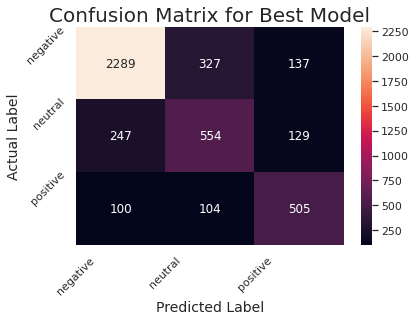

In [ ]:
# Creating a confusion matrix for the test data of our best model
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=y_pred)

#plt.figure(figsize=(15,10))                   # Increasing the size of the confusion matrix
sns.heatmap(data=cm, annot=True, fmt=".0f")   # Plotting the confusion matrix as a heatmap

plt.xlabel("Predicted Label", fontsize=14)    # Labeling the predicted axis
plt.ylabel("Actual Label", fontsize=14)       # Labeling the true axis

plt.xticks(ticks=np.arange(0,3), labels=list(ivd.values()), rotation=45)        # Placing the sentiment class names
plt.yticks(ticks=np.arange(0,3), labels=list(ivd.values()), rotation=45)        # Placing the sentiment class names

plt.title("Confusion Matrix for Best Model", fontsize=20)   # Adding a title
plt.show()

In [ ]:
# Displaying the classification report with the test data
print(classification_report(y_true=[ivd[x] for x in np.argmax(y_test, axis=1)], y_pred=[ivd[x] for x in y_pred]))

              precision    recall  f1-score   support

    negative       0.87      0.83      0.85      2753
     neutral       0.56      0.60      0.58       930
    positive       0.65      0.71      0.68       709

    accuracy                           0.76      4392
   macro avg       0.70      0.71      0.70      4392
weighted avg       0.77      0.76      0.77      4392



From the above confusion matrix and classification report the model performs best when identifying negative tweets and least well when identifying neutral tweets.  On average, if the model mis-identifies a neutral tweet it classifies the tweet as negative three times as often as positive.  Thus, our model could be said to be more conservative in nature by erring on the safe side and moving tweets it is less sure of towards the negative end of the spectrum.  This way, if a problem is arising for an airline on Twitter the company will have less negative reviews slip through their screening.

In [ ]:
# Printing the best model's test accuracy
print("Best Model Test Accuracy:", bestModel.evaluate(x=x_test, y=y_test)[1])

138/138 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.7623
Best Model Test Accuracy: 0.7622950673103333


The test accuracy shows that our model is overfit somewhat since the validation accuracy is greater than the test accuracy.

## Summary



To build this model we employed several preprocessing steps in order to clean the data.  Without cleaning the text data our model would not be able to generalize and train on the tweets. These were:
- HTML tag removal: eliminated HTML tags from the text
- Contraction removal: converted words such as can't into can not to reduce the dimensionality of our data
- Tokenization: split each tweet into individual words which will be used later as features for our model to learn from
- Number removal: removed numbers such as 10,000 from the text as the scale of the numbers should not affect this model
- Special character removal: converted any characters such as é to their nearest english equivalent
- Punctuation removal: eliminated punctuation from our model to employ a bag of words approach
  - This does remove some contextual meaning from the data however it does reduce the dimensionality of the data and is not usually helpful to the model
- Stop word removal: removed words that do not carry actual information from the text, such as "the" and "as"
- Conversion to lowercase: converted all characters to lowercase so that "The" and "the" will be the same word instead of two different words
- Lemmatize: reduced all words to a root word that is present in the dictionary striving to reduce the dimensionality of the text and get to the actual meaning of each word in the text
  - i.e. roots becomes root
- Joining the words back together: simply turned the list of separate words back into a continuous string for the vectorizing functions to operate on

We also used two different types of word vectorization: CountVectorizer and TfidfVectorizer.  Vectorizing the text data converts words into individual vectors or features for our model to train with.  In each case we set the maximum number of features (or words) to the 3000 highest weight words as to reduce training time and to have less features than the number of tweets our dataset has.  The two vectorization methods work by:
- CountVectorizer
  - Counting the frequency of each word present in a given tweet
  - Assigning that frequency as the weight of the word for that particular tweet
  - Normalizing the weights by dividing each weight by the maximum weight so they range from 0 to 1
  - The weights of words do not take into account other tweets (documents)
- TfidfVectorizer
  - Counting the frequency of each word present in a tweet
  - Dividing that count by the total number of words in that tweet
    - This is known as the term frequency
  - Counting how many documents (tweets) each word is present in
  - Dividing the total number of documents (tweets) by the previous count
  - Applying a logrithmic scale to the previous division
    - This is known as the inverse document frequency
  - Multiplying the term frequency by the inverse document frequency
    - This lowers the importance (weights) of words which appear in most of the documents while increasing the importance (weights) of words which appear in only a few of the documents